## Loading Libraries

In [88]:
import pyreadr
import pandas as pd
import numpy as np
import csv
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

## Reading in Data

In [57]:
# Reading in Data
dataset = pyreadr.read_r("../data/raw_data/brain.rda")

In [58]:
arraymeta_data = dataset['arraymeta']

In [59]:
expression_data = dataset['expression']

In [60]:
genemeta_data = dataset['genemeta']

## Initial EDA

### Counts from each brain region

In [61]:
# Determining the number of brain regions in each sample (apparently always 1)
arraymeta_data[['region.ancg', 'region.cb', 'region.dlpfc']].sum(axis=1).unique()

array([1.])

In [62]:
# Total number of samples from each brain region
arraymeta_data[['region.ancg', 'region.cb', 'region.dlpfc']].sum(axis = 0)

region.ancg     127.0
region.cb        81.0
region.dlpfc    178.0
dtype: float64

In [63]:
### Cross tab by brain region and lab
# Create factors for brain region and lab
arraymeta_data['region'] = arraymeta_data[['region.ancg', 'region.cb', 'region.dlpfc']].idxmax(axis=1).str.replace('region.', '')
arraymeta_data['lab'] = arraymeta_data[['lab.davis', 'lab.irvine', 'lab.michigan']].idxmax(axis=1).str.replace('lab.', '')

# Cross tab
cross_tab_region_lab = pd.crosstab(arraymeta_data['region'], arraymeta_data['lab'])

# Print results
print(cross_tab_region_lab)

lab     davis  irvine  michigan
region                         
ancg        0      66        61
cb         21      42        18
dlpfc      85       9        84


### Counts by age

In [64]:
### Cross tab by brain region and age
# Cross tab
cross_tab_br_age = pd.crosstab(arraymeta_data['age'], arraymeta_data['region'])


In [65]:
### Cross tab by brain region and age ranges of interest
# Split pandas dataframe by age group
def categorize_age(age):
    if age < 70:
        return '<70'
    else:
        return '>=70'

arraymeta_data['age_group'] = arraymeta_data['age'].apply(categorize_age)

# Cross tab
cross_tab_region_agegrp = pd.crosstab(arraymeta_data['region'], arraymeta_data['age_group'])

# Print results
print(cross_tab_region_agegrp)

age_group  <70  >=70
region              
ancg       104    23
cb          70    11
dlpfc      146    32


### Investigating Missingness

In [66]:
any_NaN = expression_data.isna().any().any()
any_NaN

np.False_

Evidently, there is no missing expression data.

In [67]:
inf_mask = np.isinf(expression_data.to_numpy())
has_inf = inf_mask.any()
has_inf

np.False_

Evidently, there were no spots for which there was zero count. Therefore, we can blindly convert to raw count data.

### Converting to raw counts

In [68]:
raw_counts = 2.0**expression_data

In [69]:
raw_counts

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,387.319762,99.995390,107.069361,213.580369,89.099783,167.536728,106.504334,90.602868,79.456965,77.437849,...,710.216462,614.581285,2956.635385,2536.878315,86.073393,74.141082,67.477990,61.518134,66.267422,66.697899
1,181.952916,72.796081,83.120395,142.286599,64.123319,91.517089,86.253694,68.853105,61.731534,61.713913,...,406.000000,461.920071,1911.190794,1821.064081,67.522006,57.810543,53.158979,55.608221,55.277904,59.509673
2,568.816523,182.144997,242.990359,878.528816,127.251571,266.827919,293.804928,172.850960,132.277616,144.005460,...,1725.599603,1646.239938,7159.503900,6010.863650,151.393851,137.913580,121.364314,94.579821,130.154275,126.981356
3,714.478698,150.059950,160.955522,422.935589,119.184219,252.372614,148.405140,123.347625,92.441725,102.564434,...,1621.500000,1578.500000,6217.186078,5189.241045,117.079125,89.734632,80.498447,77.718044,83.253507,81.731268
4,1853.007231,380.905140,366.904789,1056.802057,265.735867,527.142253,332.986646,277.482769,197.160947,255.521948,...,5676.013135,4519.128223,15419.000000,15838.380766,295.362776,184.489809,156.316473,152.540475,161.040698,166.389461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,884.497808,254.243143,308.459930,671.970093,192.455857,352.572584,349.122204,232.089964,181.232530,162.219440,...,2511.683933,2172.133829,7999.244943,6631.000000,195.810323,168.935993,147.511324,130.781689,148.869539,157.160307
382,1105.382192,292.750501,277.136027,677.357661,197.636075,363.512240,324.591934,221.521906,191.907476,185.552288,...,4972.108083,4024.000000,12735.500106,10587.261548,196.598365,169.877272,149.663071,133.697916,155.655627,159.864875
383,1411.067554,361.087946,299.491670,822.571064,200.483319,449.383565,513.816399,269.527099,181.641731,211.902213,...,8574.641373,8673.663027,19252.206450,18261.000000,203.691161,162.461503,144.756131,134.172796,144.830645,163.699309
384,955.962463,283.633550,324.449824,657.072527,226.728469,346.784114,343.488894,228.994897,185.009308,169.153864,...,2022.228409,2016.940801,7184.000000,6179.190081,203.775918,188.569094,159.349699,140.853810,171.583195,174.641182


In [70]:
arraymeta_data

,patient,region.ancg,region.cb,region.dlpfc,lab.davis,lab.irvine,lab.michigan,age,sex,arrayversion,region,lab,age_group
0,1834,1.0,0.0,0.0,0.0,1.0,0.0,40,M,1.0,ancg,irvine,<70
1,1834,0.0,1.0,0.0,0.0,1.0,0.0,40,M,1.0,cb,irvine,<70
2,1834,0.0,1.0,0.0,0.0,0.0,1.0,40,M,1.0,cb,michigan,<70
3,1834,0.0,0.0,1.0,1.0,0.0,0.0,40,M,1.0,dlpfc,davis,<70
4,1834,0.0,0.0,1.0,1.0,0.0,0.0,40,M,2.0,dlpfc,davis,<70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,4236,1.0,0.0,0.0,0.0,0.0,1.0,63,M,2.0,ancg,michigan,<70
382,4236,0.0,0.0,1.0,0.0,0.0,1.0,63,M,2.0,dlpfc,michigan,<70
383,4250,1.0,0.0,0.0,0.0,1.0,0.0,64,M,2.0,ancg,irvine,<70
384,4250,1.0,0.0,0.0,0.0,0.0,1.0,64,M,2.0,ancg,michigan,<70


In [71]:
raw_counts_w_covariates = pd.concat([arraymeta_data[["age", "sex", "arrayversion", "region", "lab", "age_group"]], raw_counts], axis = 1)

In [72]:
raw_counts_w_covariates_transposed = raw_counts_w_covariates.T

In [73]:
# raw_counts_w_covariates_transposed.to_csv('../data/processed_data/processed_brain.csv')

Important to note that we have much more data for the less than 70 group than for the more than 70 group. Moving on to analysis of expression rates.

## Exploring Expression Rates

In [74]:
# Expression data, no controls
expression_data_NC = expression_data.loc[:, ~expression_data.columns.str.startswith('AFFX-')]

In [75]:
# Concatenate array metadata and gene expression data
# arraymeta_n_expression = pd.concat([arraymeta_data, expression_data], axis = 1)
# arraymeta_n_expression

In [76]:
expression_data_NC

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
0,8.597381,6.643790,6.742402,7.738635,6.477350,7.388334,6.734768,6.501485,6.312102,6.274967,...,7.408764,6.194929,6.577738,6.797697,6.808708,6.657397,6.667741,6.877755,7.829561,7.007025
1,7.507421,6.185789,6.377131,7.152656,6.002777,6.515969,6.430514,6.105450,5.947936,5.947524,...,6.923182,5.905811,6.624491,6.596047,6.408747,6.282058,6.308528,6.335732,7.147709,6.905695
2,9.151820,7.508944,7.924755,9.778946,6.991540,8.059766,8.198715,7.433385,7.047425,7.169980,...,8.654531,6.993808,7.941144,8.395062,8.109849,7.638189,7.777217,8.270511,9.153971,8.376190
3,9.480747,7.229395,7.330518,8.724294,6.897049,7.979412,7.213397,6.946586,6.530472,6.680387,...,8.076502,6.508246,7.272083,7.627558,7.452189,7.398643,7.221647,7.386523,8.627450,7.436969
4,10.855653,8.573288,8.519262,10.045489,8.053849,9.042049,8.379321,8.116254,7.623230,7.997303,...,9.345059,7.533039,8.439095,8.948477,8.827563,8.402366,9.082882,8.457960,10.078353,8.583880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,9.788715,7.990065,8.268939,9.392253,7.588384,8.461776,8.447588,7.858540,7.501698,7.341803,...,8.976301,7.395264,8.056124,8.249175,8.079989,7.871611,8.174875,8.620443,9.579849,8.046445
382,10.110330,8.193528,8.114450,9.403774,7.626703,8.505860,8.342483,7.791306,7.584267,7.535682,...,9.027578,7.284062,8.125525,8.589722,8.322550,7.880925,8.260587,8.548490,9.506943,8.071258
383,10.462571,8.496206,8.226372,9.683997,7.647338,8.811804,9.005109,8.074287,7.504952,7.727255,...,9.152998,7.364501,8.079706,8.494462,8.515618,8.145256,7.924811,8.534315,9.714715,8.488281
384,9.900810,8.147884,8.341852,9.359909,7.824822,8.437894,8.424120,7.839172,7.531454,7.402192,...,9.057280,7.584480,8.151156,8.061232,8.195951,7.987534,8.040881,8.605511,9.271022,8.048346


### PCA

In [77]:
# Separating out target
brain_region_target = arraymeta_data['region']

In [78]:
# Standardize the features
X_expression_NC = StandardScaler().fit_transform(expression_data_NC)

In [79]:
# Setting number of principal components
pca = PCA(n_components = 50)

In [80]:
# Extracting principal components
principalComponents = pca.fit_transform(X_expression_NC)

In [81]:
PC_df = pd.DataFrame(data = principalComponents)
final_PC_df = pd.concat([PC_df, brain_region_target], axis = 1)
final_PC_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,region
0,-241.394620,8.389363,-0.044469,-12.885234,-2.581314,-3.055921,-14.431948,-2.148429,4.896703,7.348052,...,1.123938,0.774332,1.644602,-0.404214,1.327487,1.227765,1.777930,-2.243210,2.108389,ancg
1,-324.430258,-10.076295,37.329415,-10.567751,10.350082,0.796032,-20.941473,-4.337129,-1.204543,-1.212140,...,-2.441964,0.935480,-1.182314,0.037665,-2.220240,0.450186,-0.276765,-3.224882,0.095471,cb
2,-31.354534,-20.218450,27.855337,16.860970,5.221065,-2.054197,6.708242,-0.435252,3.779758,1.829314,...,-0.068199,2.831712,0.524246,0.002889,-0.653727,0.801152,-0.230837,-2.424099,1.681349,cb
3,-124.381406,31.720574,-2.241897,-0.279448,-21.087420,-3.231646,-8.064244,-1.411616,-11.896375,-4.504295,...,-0.813332,0.260207,-1.743713,-0.053156,1.507856,-0.119478,0.415908,-3.108655,0.879738,dlpfc
4,134.635472,25.228737,-4.712797,-18.630727,-11.384066,-8.069399,6.833284,7.110003,-14.782843,-3.171621,...,-2.633622,-0.547088,-5.109287,-0.203427,-1.595263,-1.843223,3.261417,-4.541378,4.251471,dlpfc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,49.243013,0.321841,-21.112378,-1.725965,20.123499,-6.622513,2.019680,-2.926181,-4.474775,6.585416,...,-2.293960,-2.834764,0.948414,0.004638,1.408067,2.192792,-0.493870,1.035379,0.600878,ancg
382,61.321936,17.044585,-14.799379,-13.042483,21.100090,-7.147367,6.204182,-10.142042,-4.832194,-1.425636,...,-2.984020,-2.435436,-1.754040,0.298803,1.781367,1.625958,-1.291969,-0.042419,2.307640,dlpfc
383,97.064292,33.355602,-10.021014,-18.427506,1.782453,1.041464,-5.732291,-0.345489,12.595077,13.237269,...,-0.007899,2.330667,-1.145039,0.836043,0.916518,0.129107,4.235820,2.843147,0.731816,ancg
384,64.008859,-1.617070,-18.729140,-11.610589,23.017516,-7.669948,-2.200760,-6.846546,-8.208843,6.451569,...,-0.812459,0.736765,0.653896,-0.516424,-0.524172,0.113548,-1.237630,2.281287,1.192085,ancg


In [82]:
sum((pca.explained_variance_ / sum(pca.explained_variance_))[0:3])

np.float64(0.9451304082221841)

In [83]:
# Renaming columns
n = min(50, final_PC_df.shape[1])  # just in case there are < 50 cols
new_names = {old: f"PC{i+1}" for i, old in enumerate(final_PC_df.columns[:n])}
final_PC_df = final_PC_df.rename(columns=new_names)

In [84]:
final_PC_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,region
0,-241.394620,8.389363,-0.044469,-12.885234,-2.581314,-3.055921,-14.431948,-2.148429,4.896703,7.348052,...,1.123938,0.774332,1.644602,-0.404214,1.327487,1.227765,1.777930,-2.243210,2.108389,ancg
1,-324.430258,-10.076295,37.329415,-10.567751,10.350082,0.796032,-20.941473,-4.337129,-1.204543,-1.212140,...,-2.441964,0.935480,-1.182314,0.037665,-2.220240,0.450186,-0.276765,-3.224882,0.095471,cb
2,-31.354534,-20.218450,27.855337,16.860970,5.221065,-2.054197,6.708242,-0.435252,3.779758,1.829314,...,-0.068199,2.831712,0.524246,0.002889,-0.653727,0.801152,-0.230837,-2.424099,1.681349,cb
3,-124.381406,31.720574,-2.241897,-0.279448,-21.087420,-3.231646,-8.064244,-1.411616,-11.896375,-4.504295,...,-0.813332,0.260207,-1.743713,-0.053156,1.507856,-0.119478,0.415908,-3.108655,0.879738,dlpfc
4,134.635472,25.228737,-4.712797,-18.630727,-11.384066,-8.069399,6.833284,7.110003,-14.782843,-3.171621,...,-2.633622,-0.547088,-5.109287,-0.203427,-1.595263,-1.843223,3.261417,-4.541378,4.251471,dlpfc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,49.243013,0.321841,-21.112378,-1.725965,20.123499,-6.622513,2.019680,-2.926181,-4.474775,6.585416,...,-2.293960,-2.834764,0.948414,0.004638,1.408067,2.192792,-0.493870,1.035379,0.600878,ancg
382,61.321936,17.044585,-14.799379,-13.042483,21.100090,-7.147367,6.204182,-10.142042,-4.832194,-1.425636,...,-2.984020,-2.435436,-1.754040,0.298803,1.781367,1.625958,-1.291969,-0.042419,2.307640,dlpfc
383,97.064292,33.355602,-10.021014,-18.427506,1.782453,1.041464,-5.732291,-0.345489,12.595077,13.237269,...,-0.007899,2.330667,-1.145039,0.836043,0.916518,0.129107,4.235820,2.843147,0.731816,ancg
384,64.008859,-1.617070,-18.729140,-11.610589,23.017516,-7.669948,-2.200760,-6.846546,-8.208843,6.451569,...,-0.812459,0.736765,0.653896,-0.516424,-0.524172,0.113548,-1.237630,2.281287,1.192085,ancg


In [90]:
fig = px.scatter_3d(
    final_PC_df,
    x="PC1", y="PC2", z="PC3",
    color="region",
    category_orders={"region": ["ancg", "cb", "dlpfc"]},
    opacity=0.85,
    title="3-component PCA"
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"))
fig.show()  # drag to rotate



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
regions = ["ancg", "cb", "dlpfc"]
colors  = {"ancg":"red", "cb":"green", "dlpfc":"blue"}

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type":"scene"}]*3],
    subplot_titles=regions
)

for i, reg in enumerate(regions, start=1):
    df = final_PC_df[final_PC_df["region"] == reg]
    fig.add_trace(
        go.Scatter3d(
            x=df["PC1"], y=df["PC2"], z=df["PC3"],
            mode="markers",
            marker=dict(size=3),
            name=reg,
            showlegend=False
        ),
        row=1, col=i
    )

fig.update_scenes(
    xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3",
    aspectmode="cube"
)
fig.update_layout(title="3D PCA by Region", margin=dict(l=0, r=0, b=0, t=40))
fig.show()  # drag to rotate each subplot

### t-SNE Plot

In [ ]:
# Standardize data if not done for PCA#
expression_data_NC = expression_data.loc[:, ~expression_data.columns.str.startswith('AFFX-')]
X_expression_NC = StandardScaler().fit_transform(expression_data_NC)

In [ ]:
# Changing brain region targets into numbers
brain_region_target = arraymeta_data['region']
mapping = {'cb': 0, 'dlpfc': 1, 'ancg': 2}
number_target = brain_region_target.map(mapping)

In [ ]:
# Initialize t-SNE model
tsne = TSNE(n_components = 2,
            perplexity = 5,
            random_state = 82803)

In [ ]:
# Fit t-SNE model
X_tsne = tsne.fit_transform(X_expression_NC)

In [ ]:
# Concatenate for plotting and rename
final_tsne_df = pd.concat([pd.DataFrame(X_tsne), brain_region_target], axis = 1)

# Rename
n = min(50, final_PC_df.shape[1])  # just in case there are < 50 cols
new_names = {old: f"vec{i+1}" for i, old in enumerate(final_tsne_df.columns[:n])}
final_tsne_df = final_tsne_df.rename(columns=new_names)

In [ ]:
final_tsne_df

,vec1,vec2,vec3
0,-28.751646,-29.196880,ancg
1,-40.745319,-30.511812,cb
2,22.039387,-22.536015,cb
3,38.649826,-5.875682,dlpfc
4,-50.947140,22.774872,dlpfc
...,...,...,...
381,-19.817881,30.846157,ancg
382,-19.366108,32.629776,dlpfc
383,-39.712090,44.032543,ancg
384,-20.737617,30.470827,ancg


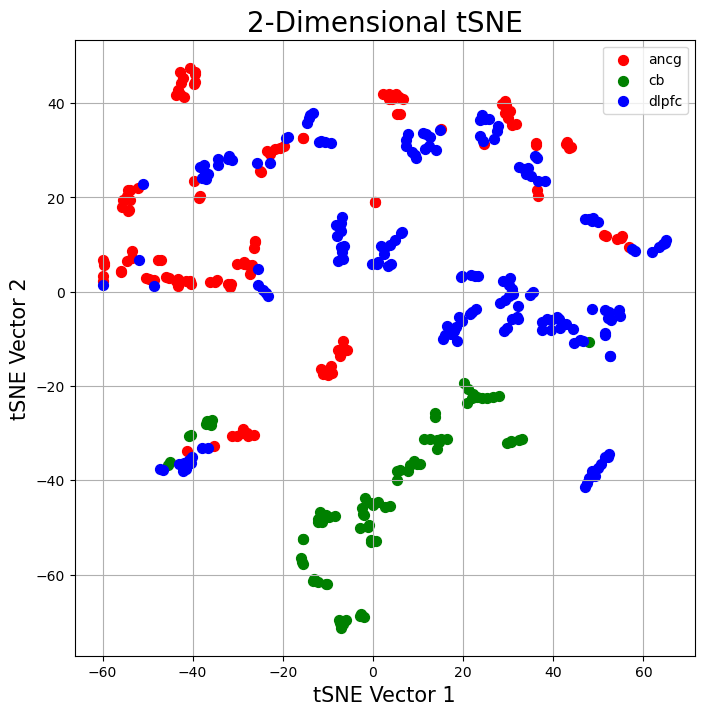

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('tSNE Vector 1', fontsize = 15)
ax.set_ylabel('tSNE Vector 2', fontsize = 15)
ax.set_title('2-Dimensional tSNE', fontsize = 20)

targets = ['ancg', 'cb', 'dlpfc']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_tsne_df['vec3'] == target
    ax.scatter(final_tsne_df.loc[indicesToKeep, 'vec1']
               , final_tsne_df.loc[indicesToKeep, 'vec2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Verify one-hot uniqueness (should be {1.0} if encoded as one-hot):
 region sums unique: [1.]
 lab sums unique: [1.]

Counts by factor:
region
ancg     127
cb        81
dlpfc    178
Name: count, dtype: int64
lab
davis       106
irvine      117
michigan    163
Name: count, dtype: int64
version
unknown    386
Name: count, dtype: int64

Chi-square assoc p-values (lower => stronger association):
 region×lab     p = 1.8379889422078603e-29
 region×version p = 1.0
 lab×version    p = 1.0


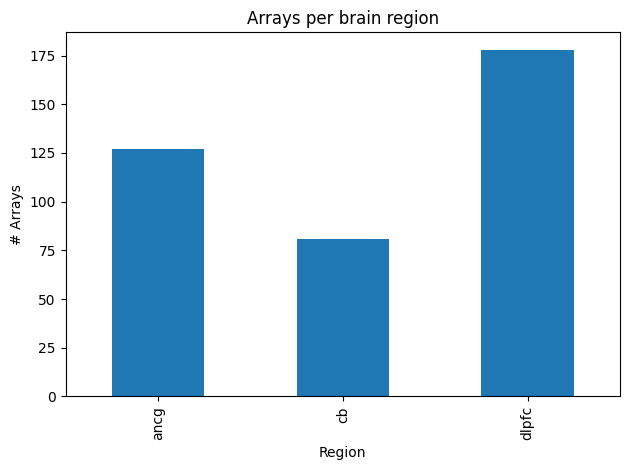

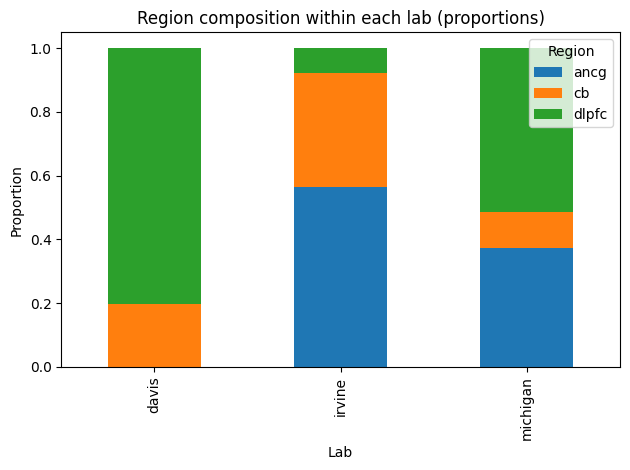

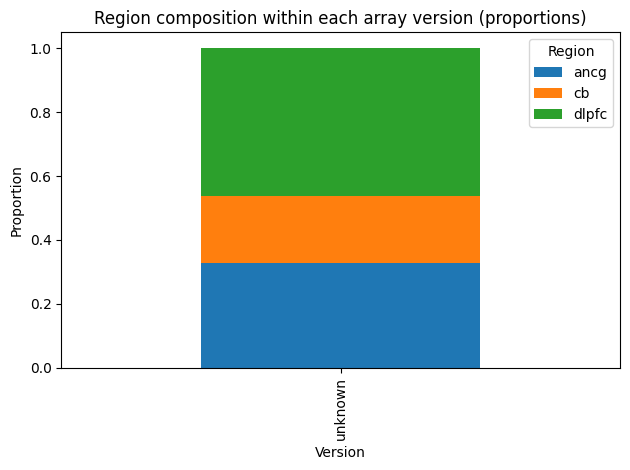

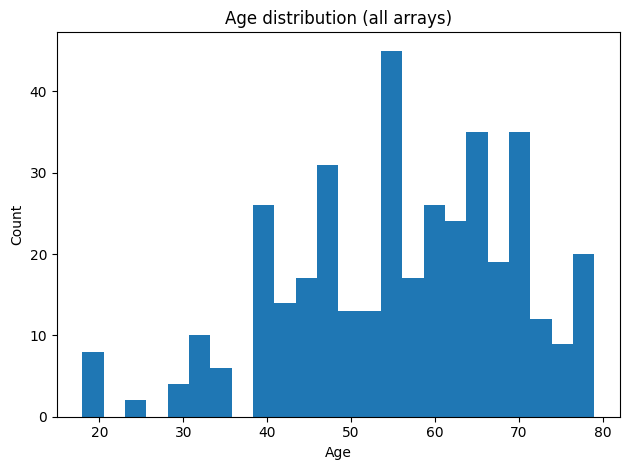

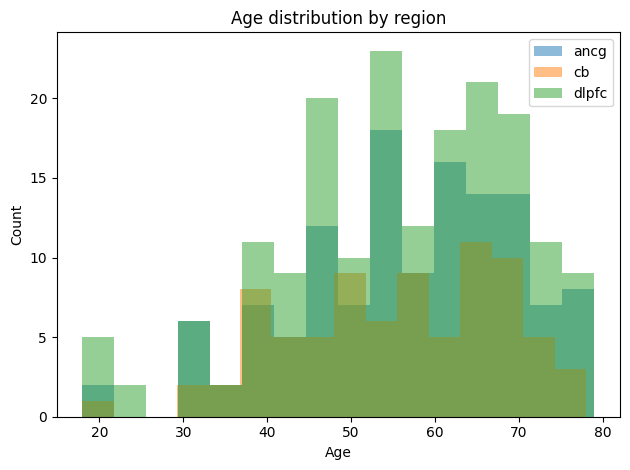

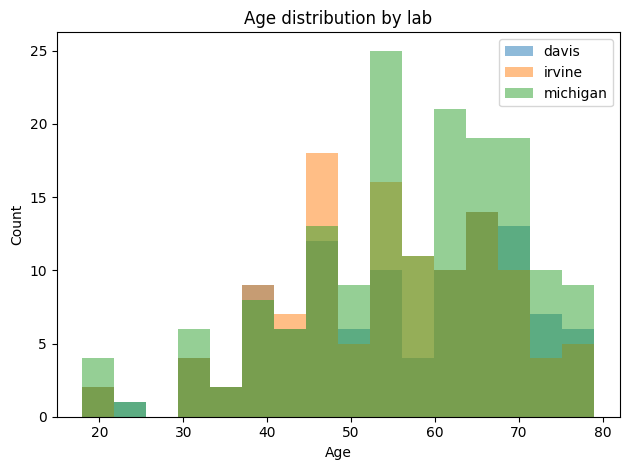

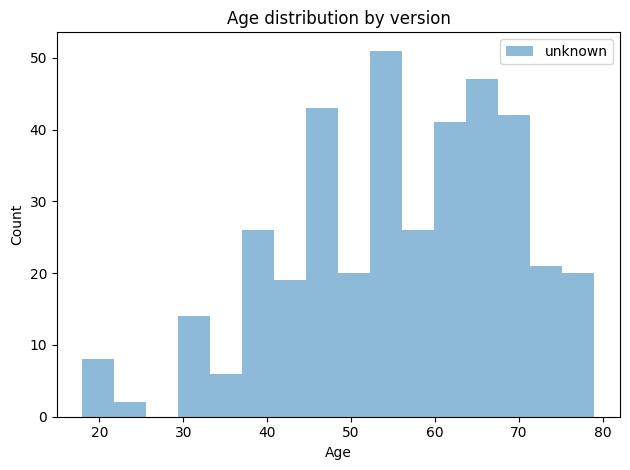

<Figure size 640x480 with 0 Axes>

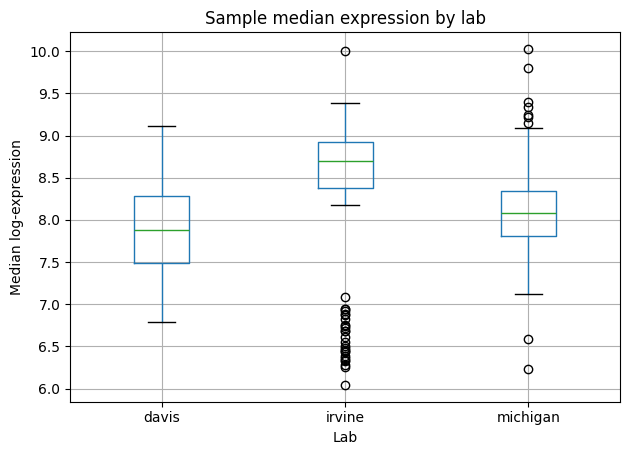

<Figure size 640x480 with 0 Axes>

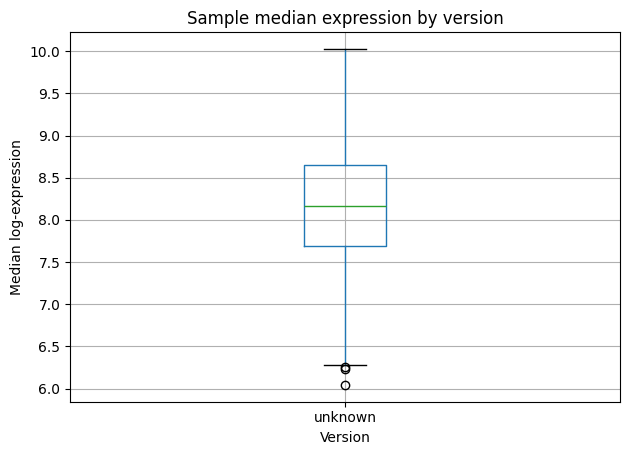

<Figure size 640x480 with 0 Axes>

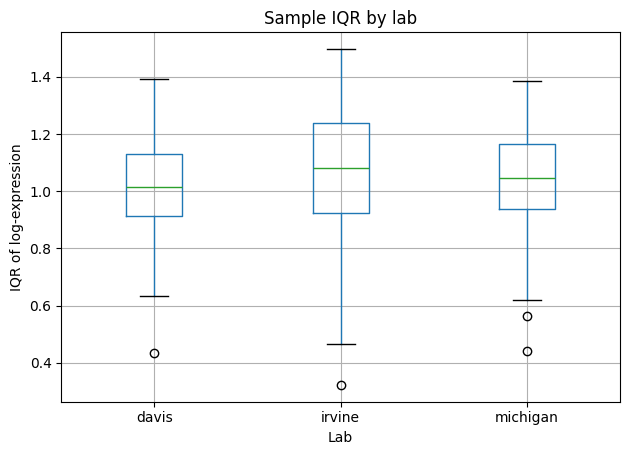

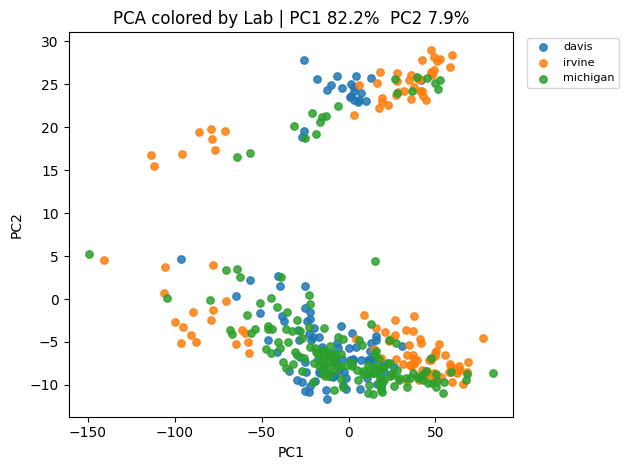

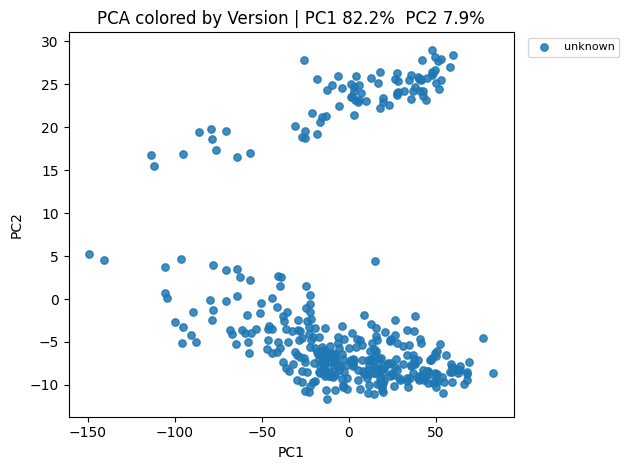

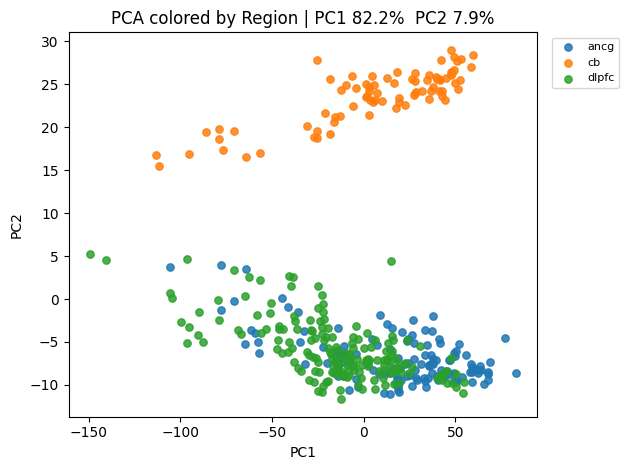

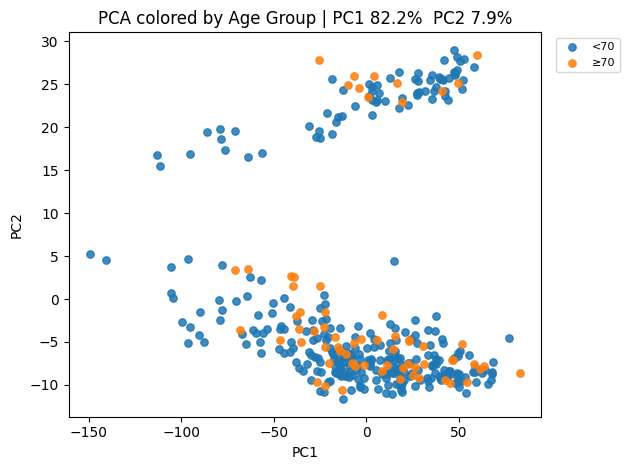

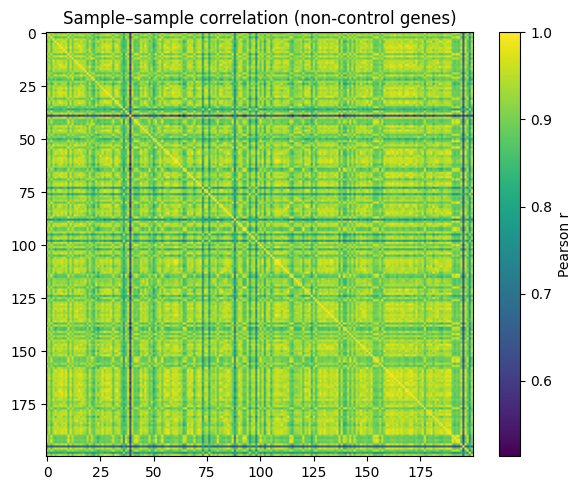

In [91]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---------- A) Lightweight auto-inference (no explicit if/else chains) ----------
def onehot_to_factor(df, prefix):
    cols = [c for c in df.columns if c.startswith(prefix)]
    if cols:
        # pick the argmax; verify rows are (nearly) one-hot
        fac = df[cols].idxmax(axis=1).str.replace(prefix, '', regex=False)
        sums = df[cols].sum(axis=1)
        unique_sums = np.sort(sums.unique())
        return fac, cols, unique_sums
    # fallback: use a single column if present (e.g., 'region', 'lab', 'version')
    base = prefix[:-1]  # 'region.' -> 'region'
    if base in df.columns:
        return df[base].astype(str), [], np.array([np.nan])
    # not found
    return pd.Series(['unknown']*len(df), index=df.index), [], np.array([np.nan])

arraymeta_ = arraymeta_data.copy()

region, region_cols, region_sum_uni = onehot_to_factor(arraymeta_, 'region.')
lab,    lab_cols,    lab_sum_uni    = onehot_to_factor(arraymeta_, 'lab.')
version, ver_cols,   ver_sum_uni    = onehot_to_factor(arraymeta_, 'version.')

arraymeta_['region']  = region
arraymeta_['lab']     = lab
arraymeta_['version'] = version
arraymeta_['age_group'] = np.where(arraymeta_['age'] < 70, '<70', '≥70')

expr_nc = expression_data_NC

# ---------- B) Quick verification tables (concise, to ensure factors look sane) ----------
print("Verify one-hot uniqueness (should be {1.0} if encoded as one-hot):")
if len(region_cols): print(" region sums unique:", region_sum_uni)
if len(lab_cols):    print(" lab sums unique:", lab_sum_uni)
if len(ver_cols):    print(" version sums unique:", ver_sum_uni)

print("\nCounts by factor:")
print(arraymeta_['region'].value_counts().sort_index())
print(arraymeta_['lab'].value_counts().sort_index())
print(arraymeta_['version'].value_counts().sort_index())

print("\nChi-square assoc p-values (lower => stronger association):")
def chisq(a,b):
    ct = pd.crosstab(a,b)
    try:
        return stats.chi2_contingency(ct)[1]
    except Exception:
        return np.nan
print(" region×lab     p =", chisq(arraymeta_['region'], arraymeta_['lab']))
print(" region×version p =", chisq(arraymeta_['region'], arraymeta_['version']))
print(" lab×version    p =", chisq(arraymeta_['lab'], arraymeta_['version']))

# ---------- C) Composition / imbalance figures ----------
plt.figure()
arraymeta_['region'].value_counts().sort_index().plot(kind='bar')
plt.title('Arrays per brain region'); plt.xlabel('Region'); plt.ylabel('# Arrays')
plt.tight_layout(); plt.show()

ct_lab_region = pd.crosstab(arraymeta_['lab'], arraymeta_['region'])
(ct_lab_region.div(ct_lab_region.sum(axis=1), axis=0)).plot(kind='bar', stacked=True)
plt.title('Region composition within each lab (proportions)')
plt.xlabel('Lab'); plt.ylabel('Proportion'); plt.legend(title='Region')
plt.tight_layout(); plt.show()

ct_ver_region = pd.crosstab(arraymeta_['version'], arraymeta_['region'])
(ct_ver_region.div(ct_ver_region.sum(axis=1), axis=0)).plot(kind='bar', stacked=True)
plt.title('Region composition within each array version (proportions)')
plt.xlabel('Version'); plt.ylabel('Proportion'); plt.legend(title='Region')
plt.tight_layout(); plt.show()

# ---------- D) Age structure ----------
plt.figure()
arraymeta_['age'].plot(kind='hist', bins=24)
plt.title('Age distribution (all arrays)')
plt.xlabel('Age'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

for fac in ['region','lab','version']:
    plt.figure()
    for lvl, g in arraymeta_.groupby(fac):
        plt.hist(g['age'].dropna(), bins=16, alpha=0.5, label=str(lvl))
    plt.title(f'Age distribution by {fac}')
    plt.xlabel('Age'); plt.ylabel('Count'); plt.legend()
    plt.tight_layout(); plt.show()

# ---------- E) Raw intensity QC (whole-matrix look) ----------
sample_median = expr_nc.median(axis=1)
sample_iqr    = expr_nc.quantile(0.75, axis=1) - expr_nc.quantile(0.25, axis=1)

plt.figure()
arraymeta_.assign(median=sample_median).boxplot(column='median', by='lab')
plt.suptitle(''); plt.title('Sample median expression by lab')
plt.xlabel('Lab'); plt.ylabel('Median log-expression')
plt.tight_layout(); plt.show()

plt.figure()
arraymeta_.assign(median=sample_median).boxplot(column='median', by='version')
plt.suptitle(''); plt.title('Sample median expression by version')
plt.xlabel('Version'); plt.ylabel('Median log-expression')
plt.tight_layout(); plt.show()

plt.figure()
arraymeta_.assign(iqr=sample_iqr).boxplot(column='iqr', by='lab')
plt.suptitle(''); plt.title('Sample IQR by lab')
plt.xlabel('Lab'); plt.ylabel('IQR of log-expression')
plt.tight_layout(); plt.show()

# ---------- F) PCA: biology vs batch ----------
# Use top-variable non-control genes for stability
gene_var = expr_nc.var(axis=0)
topk = min(2000, gene_var.shape[0])
top_idx = np.argsort(gene_var.values)[-topk:]
X = expr_nc.iloc[:, top_idx].to_numpy()
Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

pca = PCA(n_components=2, random_state=0).fit(Xz)
Z = pca.transform(Xz)
var1, var2 = pca.explained_variance_ratio_[:2]

def pc_scatter(factor, title):
    plt.figure()
    for lvl, idx in arraymeta_.groupby(factor).groups.items():
        idx = np.array(list(idx))
        plt.scatter(Z[idx,0], Z[idx,1], s=28, alpha=0.85, label=str(lvl))
    plt.title(f'{title} | PC1 {var1*100:.1f}%  PC2 {var2*100:.1f}%')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', fontsize=8)
    plt.tight_layout(); plt.show()

pc_scatter('lab', 'PCA colored by Lab')
pc_scatter('version', 'PCA colored by Version')
pc_scatter('region', 'PCA colored by Region')
pc_scatter('age_group', 'PCA colored by Age Group')

# ---------- G) Sample–sample correlation heatmap ----------
max_n = 200
if expr_nc.shape[0] > max_n:
    sel = np.random.RandomState(0).choice(expr_nc.shape[0], size=max_n, replace=False)
    Xsub = expr_nc.iloc[sel]
else:
    Xsub = expr_nc

corr = np.corrcoef(Xsub, rowvar=True)
plt.figure(figsize=(6,5))
plt.imshow(corr, aspect='auto')
plt.colorbar(label='Pearson r')
plt.title('Sample–sample correlation (non-control genes)')
plt.tight_layout(); plt.show()


In [92]:
# Promote arrayversion -> version (string, cleaned)
arraymeta_data['version'] = (
    arraymeta_data['arrayversion']
    .astype(str)
    .str.strip()
    .str.replace(r'^\s*nan\s*$', 'missing', regex=True)
)

# Optional: normalize labels (edit the map if your values differ)
norm_map = {
    '1': 'v1', '2': 'v2',
    'V1': 'v1', 'V2': 'v2',
    'hgu133a': 'v1', 'hgu133plus2': 'v2'
}
arraymeta_data['version'] = arraymeta_data['version'].replace(norm_map)

# Sanity check
print("version levels:", arraymeta_data['version'].value_counts(dropna=False))
print("n_missing version:", (arraymeta_data['version'].isin(['missing'])).sum())


version levels: version
1.0    240
2.0    146
Name: count, dtype: int64
n_missing version: 0


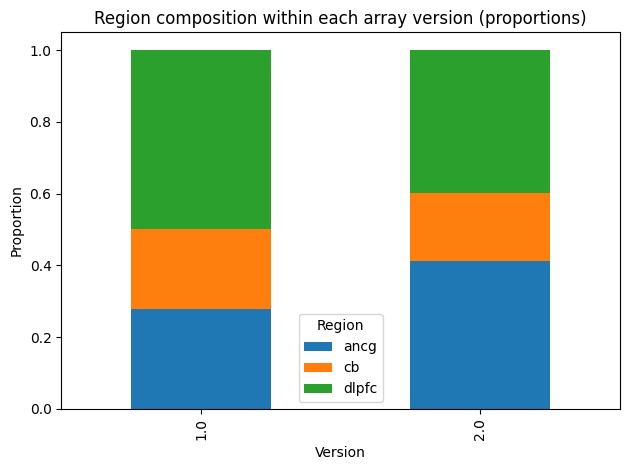

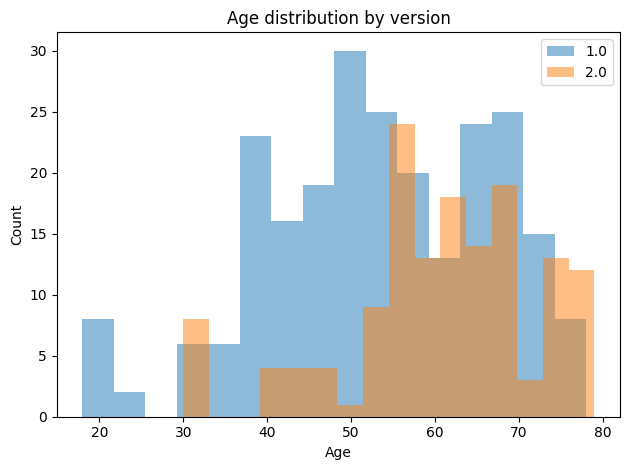

<Figure size 640x480 with 0 Axes>

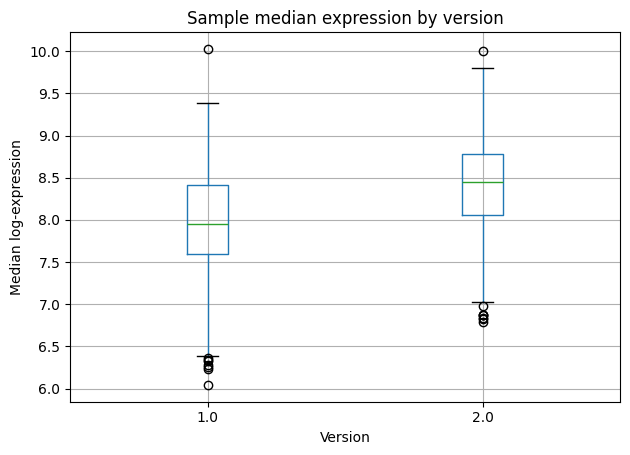

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Region composition within each array version
ct_ver_region = pd.crosstab(arraymeta_data['version'], arraymeta_data['region'])
(ct_ver_region.div(ct_ver_region.sum(axis=1), axis=0)).plot(kind='bar', stacked=True)
plt.title('Region composition within each array version (proportions)')
plt.xlabel('Version'); plt.ylabel('Proportion'); plt.legend(title='Region')
plt.tight_layout(); plt.show()

# Age distribution by version
plt.figure()
for ver, g in arraymeta_data.groupby('version'):
    plt.hist(g['age'].dropna(), bins=16, alpha=0.5, label=str(ver))
plt.title('Age distribution by version')
plt.xlabel('Age'); plt.ylabel('Count'); plt.legend()
plt.tight_layout(); plt.show()

# Median expression by version (uses your non-control matrix)
sample_median = expression_data_NC.median(axis=1)
plt.figure()
arraymeta_data.assign(median=sample_median).boxplot(column='median', by='version')
plt.suptitle(''); plt.title('Sample median expression by version')
plt.xlabel('Version'); plt.ylabel('Median log-expression')
plt.tight_layout(); plt.show()


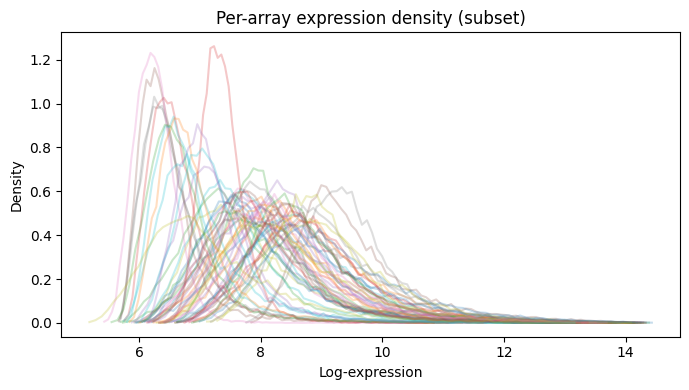

In [94]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

expr_nc = expression_data_NC

# Draw a manageable subset of arrays to avoid spaghetti
draw = min(60, expr_nc.shape[0])
idx_draw = np.random.RandomState(42).choice(expr_nc.index, size=draw, replace=False)

plt.figure(figsize=(7,4))
for i in idx_draw:
    y = expr_nc.loc[i].values
    hist, bin_edges = np.histogram(y, bins=80, density=True)
    x = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.plot(x, hist, alpha=0.25)
plt.title('Per-array expression density (subset)')
plt.xlabel('Log-expression'); plt.ylabel('Density')
plt.tight_layout(); plt.show()


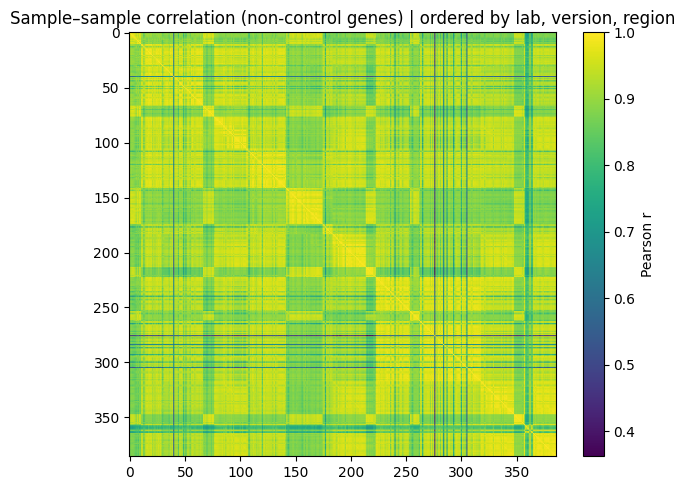

In [95]:
# Order samples by (lab, version, region) to reveal blocks
order_cols = [c for c in ['lab','version','region'] if c in arraymeta_data.columns]
order = arraymeta_data.sort_values(order_cols).index if order_cols else expr_nc.index

X = expr_nc.loc[order]
corr = np.corrcoef(X, rowvar=True)

plt.figure(figsize=(6,5))
plt.imshow(corr, aspect='auto')
plt.colorbar(label='Pearson r')
ttl = 'Sample–sample correlation (non-control genes)'
if order_cols: ttl += f' | ordered by {", ".join(order_cols)}'
plt.title(ttl)
plt.tight_layout(); plt.show()
